In [0]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import numpy as np

# Load Dataset

In [0]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url, error_bad_lines=False)

data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0,0.0,0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0,0.0,0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0,0.0,0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0,0.0,0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0,0.0,0


# Make it Simple

In [0]:
df_korea = data[data['Country/Region'] == 'Korea, South']

df_korea = np.column_stack([df_korea.Date, df_korea.Confirmed])
df_korea =  pd.DataFrame(df_korea)

df_korea = df_korea.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
df_korea = df_korea.drop("index", axis=1)

# df_korea = df_korea.append([
#   {'date': pd.to_datetime('2020-03-22'), 'confirmed': 8,897}], ignore_index=True)

df_korea.tail()

,date,confirmed
62,2020-03-24,9037
63,2020-03-25,9137
64,2020-03-26,9241
65,2020-03-27,9332
66,2020-03-28,9478


# Plot

In [0]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

fig

# Facebook Prophet

In [0]:
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
62,2020-03-24,9037
63,2020-03-25,9137
64,2020-03-26,9241
65,2020-03-27,9332
66,2020-03-28,9478


# Create a Model

# Add changepoints to Make More Flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [0]:
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible
    changepoint_range=0.9, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Plot changepoints

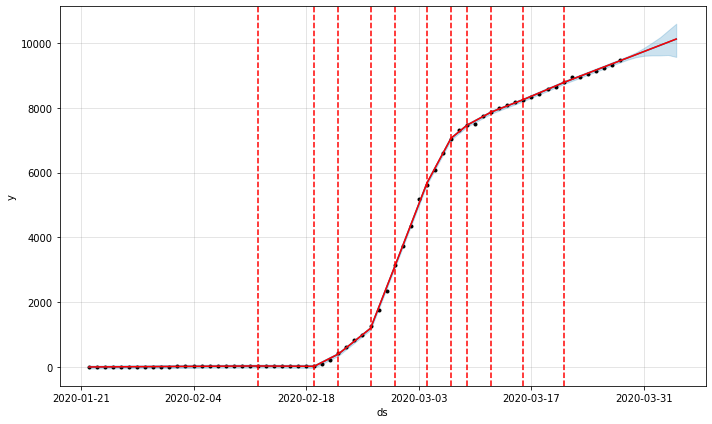

In [0]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [0]:
re_korea = data[data['Country/Region'] == 'Korea, South']

re_korea = np.column_stack([re_korea.Date, re_korea.Recovered])
re_korea =  pd.DataFrame(re_korea)

re_korea = re_korea.reset_index().rename(columns={0: 'date', 1: 'recover'})
re_korea = re_korea.drop("index", axis=1)

# re_korea = re_korea.append([
#   {'date': pd.to_date time('2020-03-15'), 'recover': 834}], ignore_index=True)

re_korea.tail()

,date,recover
62,2020-03-24,3507
63,2020-03-25,3730
64,2020-03-26,4144
65,2020-03-27,4528
66,2020-03-28,4811


In [0]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=re_korea.date,
        y=re_korea.recover,
        name='Recovered in Korea'
    )
)

In [0]:
re_prophet = re_korea.rename(columns={
    'date': 'ds',
    'recover': 'y'
})

re_prophet.tail()

,ds,y
62,2020-03-24,3507
63,2020-03-25,3730
64,2020-03-26,4144
65,2020-03-27,4528
66,2020-03-28,4811


In [0]:
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible
    changepoint_range=0.99, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(re_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

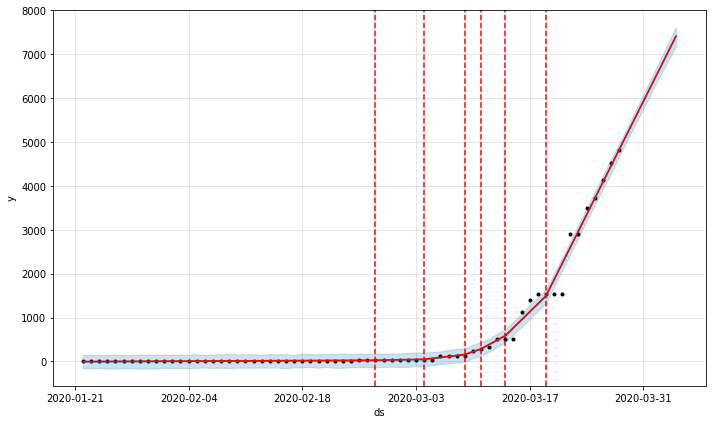

In [0]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [0]:
de_korea = data[data['Country/Region'] == 'Korea, South']

de_korea = np.column_stack([de_korea.Date, de_korea.Deaths])
de_korea =  pd.DataFrame(de_korea)

de_korea = de_korea.reset_index().rename(columns={0: 'date', 1: 'death'})
de_korea = de_korea.drop("index", axis=1)

# de_korea = de_korea.append([
#   {'date': pd.to_date time('2020-03-15'), 'recover': 834}], ignore_index=True)

de_korea.tail()

,date,death
62,2020-03-24,120
63,2020-03-25,126
64,2020-03-26,131
65,2020-03-27,139
66,2020-03-28,144


In [0]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=de_korea.date,
        y=de_korea.death,
        name='Death in Korea'
    )
)

In [0]:
de_prophet = de_korea.rename(columns={
    'date': 'ds',
    'death': 'y'
})
de_prophet.tail()

,ds,y
62,2020-03-24,120
63,2020-03-25,126
64,2020-03-26,131
65,2020-03-27,139
66,2020-03-28,144


In [0]:
m = Prophet(
    changepoint_prior_scale=0.4, # increasing it will make the trend more flexible
    changepoint_range=0.99, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(de_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

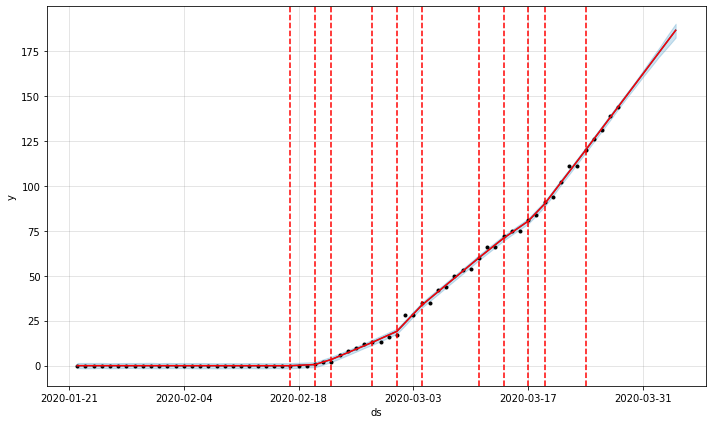

In [0]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)